In [3]:
#@ Import
import numpy as np
from numpy.fft import fft, fftfreq
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib import ticker
from matplotlib import colors
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, HTML
import scipy
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

#@ Plotting

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
        
params = {
   'axes.labelsize': 7,
   'axes.spines.top'  : False ,
   'axes.spines.right'  : False ,
   'axes.linewidth' : 0.5,
   'axes.unicode_minus' : False,
   'font.size': 7,
   'legend.fontsize': 7,
   "legend.title_fontsize" : 7,
   'xtick.major.top'      : False,
   'ytick.major.right'      : False,
    'xtick.labelsize'      : 7 ,
    'ytick.labelsize'     : 7 ,
   'figure.figsize': [2,2],
   'lines.linewidth' : 0.5,
'mathtext.fontset' : 'cm',
"figure.subplot.left"    : 0.05 , # the left side of the subplots of the figure
"figure.subplot.right"   : 0.95   , # the right side of the subplots of the figure
"figure.subplot.bottom"   : 0.05  ,  # the bottom of the subplots of the figure
"figure.subplot.top"     : 0.95 ,
    "figure.dpi" : 200 ,
   'xtick.major.pad' : 1,
   'ytick.major.pad' : 1,
    'xtick.major.width':   0.5,
   'xtick.major.size':   1.5,
    'ytick.major.width':   0.5,
   'ytick.major.size':   1.5,
    'pdf.fonttype': 42,
    'pdf.use14corefonts'  : True
}
#Matplotlib.rcParams[‘pdf.- fonttype’]=42
mpl.rcParams.update(params)

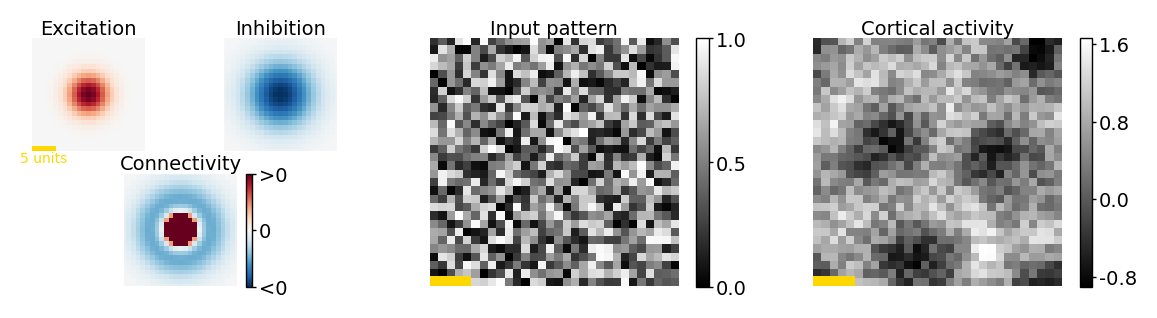

In [37]:
#@ Helper functions
def gaussian(x,mu,sigma):
    norm = 1./(np.sqrt(2*np.pi)*sigma)
    log_term = -0.5*(x-mu)**2/sigma**2
    return norm*np.exp(log_term)

def get_random_field(N,M,N_fields=1, sig1=2, sig2=4, seed=241028):
    #N, M : grid size
    #N_fields: number of fields
    #sig1, sig2: kernel size

    #generate random input
    rng_fields = np.random.default_rng(seed)
    #sample from normal distribution, other distributions possible
    input_rnd = rng_fields.normal(size=[N_fields, N, M])

    if np.allclose(0,sig1):
        bp_field = np.copy(input_rnd)
    else:
        #apply convolution
        #use convolution with MH to get spatial scale in noisy input
        #define convolutio kernels
        x,y = np.meshgrid(np.linspace(-N//2+1,N//2,N),np.linspace(-M//2+1,M//2,M))
        kern1 = 1./(np.sqrt(np.pi*2)*sig1)**2*np.exp((-x**2-y**2)/2./sig1**2)
        kern2 = 1./(np.sqrt(np.pi*2)*sig2)**2*np.exp((-x**2-y**2)/2./sig2**2)
        input_smo = np.real(np.fft.ifft2(np.fft.fft2(
            kern1-kern2)[None,:,:]*np.fft.fft2(
                input_rnd,axes=(1,2)), axes=(1,2)))
        bp_field = input_smo.copy()

    return bp_field


def normalize_w(matrix, target_max_eigenvalue):
    # Calculate the eigenvalues of the matrix
    eigenvalues = np.linalg.eigvals(matrix)
    
    # Find the maximum real eigenvalue
    max_real_eigenvalue = max(eigenvalues.real)
    
    # Calculate the normalization factor
    normalization_factor = target_max_eigenvalue / max_real_eigenvalue
    
    # Normalize the matrix
    normalized_matrix = matrix * normalization_factor
    
    return normalized_matrix

def get_input(M,N,index=None):
    x,y = np.meshgrid(np.linspace(-N//2+1,N//2,N),np.linspace(-M//2+1,M//2,M))
    kern1 = 1./(np.sqrt(np.pi*2))**2*np.exp((-x**2-y**2)/2.)
    kern2 = 1./(np.sqrt(np.pi*2))**2*np.exp((-x**2-y**2)/2.)
    #generate random input
    rng_start_activity = np.random.RandomState(index)
    input_rnd = rng_start_activity.rand(M, N)
    #apply convolution
#     input_smo = np.real(np.fft.ifft2(np.fft.fft2(kern1-kern2)[:,:]*np.fft.fft2(input_rnd,axes=(0,1)), axes=(0,1)))
    return input_rnd
    


def get_fp(M,N,w,i):
    W = np.reshape(w, (M*N, M*N))
    I = np.reshape(i, (M*N,1))
    K = np.linalg.inv(np.diag(np.diag(np.ones((M*N,M*N)))) - W)
    fp = np.matmul(K, I)
    return fp 

def get_2d_mh(M,N,r,sigma_e, sigma_i, amp_e,amp_i,heter=0,
             sigma_bp1=2, sigma_bp2=6, strength_RF=0):
    coord_x,coord_y= np.meshgrid(np.arange(N),np.arange(M)) #N:x dimension; M:y dim.
    deltax = coord_x[:,:,None,None]-coord_x[None,None,:,:]
    deltay = coord_y[:,:,None,None]-coord_y[None,None,:,:]
    absdeltax = np.abs(deltax)
    absdeltay = np.abs(deltay)
    idxx = np.argmin([absdeltax, N-absdeltax],axis=0)
    idxy = np.argmin([absdeltay, M-absdeltay],axis=0)

    deltax = deltax*(1-idxx) + np.sign(deltax)*(absdeltax-N)*idxx
    deltay = deltay*(1-idxy) + np.sign(deltay)*(absdeltay-M)*idxy
    delta = np.sqrt(deltax**2 + deltay**2)    
    
    we = amp_e*gaussian(delta,0,sigma_e)
    wi = amp_i*gaussian(delta,0,sigma_i)


    #create pertubation field
    perturbfield = get_random_field(N,M,N_fields=1, 
                                   sig1=sigma_bp1,
                                   sig2=sigma_bp2,
                                   seed=241028)   
    perturbfield -= np.nanmean(perturbfield)
    perturbfield /= np.linalg.norm(perturbfield)
    #print(np.nanmean(perturbfield), np.nanstd(perturbfield))
    pertubationField = (1 + strength_RF*perturbfield)
    pertubationField[pertubationField<0]=0
    we = we*pertubationField[None,None,:,:]
    wi = wi*pertubationField[None,None,:,:]

    
    w_rec = we - wi
    
    #Normalize so that mean 0 and std 1
    w_rec = w_rec.reshape(N*M, N*M)
    W_rec_inhib = w_rec.copy()
    W_rec_inhib[W_rec_inhib>0]=np.nan
    W_rec_exc = w_rec.copy()
    W_rec_exc[W_rec_exc<0]=np.nan

    sum_exc =np.nansum(W_rec_exc, axis=1)
    sum_inhib =-1*np.nansum(W_rec_inhib, axis=1)

    #multiply with exc/inh normalization factor for each unit
    w_rec = w_rec * (sum_inhib/sum_exc)[:,None]
    #replace with old inhibitory connections
    w_rec[~np.isnan(W_rec_inhib)] = W_rec_inhib[~np.isnan(W_rec_inhib)]
    #normalize by std
    w_rec /= np.std(w_rec, axis=1)[:,None]
    
    
    w = normalize_w(w_rec.reshape(M*N,M*N),r)
    we = we.reshape(N*M, N*M)
    wi = wi.reshape(N*M, N*M)
    return w, we, wi

def Difference_of_gaussians_widget( rec_strength=0.95,                                   
    strength_RF=0,
    width_inhib=5,    
    width_exec=3,
    strength_inhib=1,
    strength_exec=1,
    N=30,
    input_structure='Noise A'):

    color_scalebar='gold'
    
    cutout_size=int(2.5*max(width_exec,width_inhib))
    #build connectivity
    M=N
    mexican_hat, we, wi = get_2d_mh(M,N,rec_strength, width_exec, width_inhib, strength_exec, strength_inhib,
                           strength_RF=strength_RF) #(M*N,M*N)

    if input_structure=='Noise A':
        inp = get_input(M,N)
    if input_structure=='Pattern A':
        structure= get_random_field(N,M,N_fields=1, sig1=4, sig2=8, seed=10)
        struct_bin = 1*(structure>0)
        inp = 1+0.1*struct_bin

    if input_structure=='Pattern B':
        structure= get_random_field(N,M,N_fields=1, sig1=0.8, sig2=1.5, seed=5)
        struct_bin = 1*(structure>0)
        inp = 1+0.1*struct_bin

    if input_structure=='Noise B':
        noise = get_input(M,N)
        inp = 1+0.1*noise
    fp = get_fp(M,N,mexican_hat,inp).reshape((M,N))

    layout = mosaic = """
    AABBDDDDEEEE
    .CC.DDDDEEEE
    """
    fig, axs = plt.subplot_mosaic(layout,
                figsize=cm2inch(16,3.5))

    #input pattern
    axI = axs['D']
    im=axI.imshow(inp.reshape((M,N)),cmap='binary_r', vmin=0, vmax=max(1, np.max(inp)))    
    axI.margins(x=1)
    axI.spines['bottom'].set_visible(False)
    axI.spines['right'].set_visible(False)
    axI.spines['left'].set_visible(False)
    axI.set_yticks([])
    axI.set_xticks([])
    axI.set_title('Input pattern',  fontsize=7, pad=0)
    cb=fig.colorbar(im, ax=axI)
    tick_locator = ticker.MaxNLocator(nbins=2, min_n_ticks=3)
    cb.locator = tick_locator
    cb.update_ticks()
    rect = patches.Rectangle((-0.5,N-1.75), 5, 1.2, linewidth=0, edgecolor='None', facecolor=color_scalebar)  
    axI.add_patch(rect)
    
    
    #plot connectivity
    ax1 = axs['C']
    idx=int(N/2*(N+1))
    im_min = np.min(mexican_hat[idx])
    im=ax1.imshow(mexican_hat[idx].reshape((M,N)),
                  cmap='RdBu_r',
                  vmax=-2*im_min,
                  vmin=2*im_min)

    ax1.spines['bottom'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
#     ax1.legend(frameon=False, loc='upper right',
#               handlelength=0.5, handletextpad=0.1, borderpad=-0.2)
    ax1.set_xticks([] )
    ax1.set_yticks([])
    ax1.set_title('Connectivity', fontsize=7, pad=0)
    i,j = np.unravel_index(idx, (N,M))    
    ax1.axis([i-cutout_size,i+cutout_size,j-cutout_size,j+cutout_size])
    cb=fig.colorbar(im, ax=ax1,
                orientation='vertical', 
           ticks=[-2*im_min,0,2*im_min]
                   )
    cb.ax.set_yticklabels(['>0','0', '<0'])
    # cb.ax.set_yticklabels([])

    #only excitatory    
    ax1 = axs['A']
    im=ax1.imshow(we[idx].reshape((M,N)),
                  cmap='RdBu_r', norm=mpl.colors.TwoSlopeNorm(0) )
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.set_xticks([] )
    ax1.set_yticks([])
    ax1.set_title('Excitation', fontsize=7, pad=0)
    ax1.axis([i-cutout_size,i+cutout_size,j-cutout_size,j+cutout_size])
    # Create a Rectangle patch
    rect = patches.Rectangle((i-cutout_size,i-cutout_size), 5, 1.2, linewidth=0, edgecolor='None', facecolor=color_scalebar)    
    # Add the patch to the Axes
    ax1.add_patch(rect)
    ax1.text(0.1, 0, '5 units', transform=ax1.transAxes, fontsize=5, va='top', ha='center', color=color_scalebar)


    #only inhibitory
    ax1 = axs['B']
    im=ax1.imshow(-1*wi[idx].reshape((M,N)),
                  cmap='RdBu_r', norm=mpl.colors.TwoSlopeNorm(0 ))
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.set_xticks([] )
    ax1.set_yticks([])
    ax1.set_title('Inhibition', fontsize=7, pad=0)
    ax1.axis([i-cutout_size,i+cutout_size,j-cutout_size,j+cutout_size])
    #fig.colorbar(im, ax=ax1)
    
    #plot pattern
    ax2 = axs['E']
    im2=ax2.imshow(fp.reshape((M,N)),cmap='binary_r')    
    ax2.margins(x=1)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_title('Cortical activity', fontsize=7, pad=0)
    cb=fig.colorbar(im2, ax=ax2)
    tick_locator = ticker.MaxNLocator(nbins=2, min_n_ticks=3)
    cb.locator = tick_locator
    cb.update_ticks()
    rect = patches.Rectangle((-0.5,N-1.75), 5, 1.2, linewidth=0, edgecolor='None', facecolor=color_scalebar) 
    ax2.add_patch(rect)
    # ax2.text(0.05, -0.05, '5 units', transform=ax.transAxes, fontsize=7, va='top', ha='left')

    
    plt.show()
    fig.savefig("test.pdf")

Difference_of_gaussians_widget()


In [38]:
#@ HTML

display(HTML("<style>.widget-label { font-size: 18px; }</style>"))

# Define sliders with custom layout
rec_strength_slider = widgets.FloatSlider(value=0.99, min=0.0, max=1.0, step=0.01, description='Rec Strength',
                                          style={'description_width': 'initial'},
                                          layout=widgets.Layout(width='300px'))
width_inhib_slider = widgets.FloatSlider(value=3.0, min=0.01, max=5, step=0.05, description='Width Inhib',
                                         style={'description_width': 'initial'},
                                         layout=widgets.Layout(width='300px'))
strength_inhib_slider = widgets.FloatSlider(value=1, min=0, max=5, step=0.05, description='Strength Inhib',
                                            style={'description_width': 'initial'},
                                            layout=widgets.Layout(width='300px'))
width_exec_slider = widgets.FloatSlider(value=1.5, min=0.01, max=5, step=0.05, description='Width Exec',
                                        style={'description_width': 'initial'},
                                        layout=widgets.Layout(width='300px'))
strength_exec_slider = widgets.FloatSlider(value=1, min=0, max=5, step=0.05, description='Strength Exec',
                                           style={'description_width': 'initial'},
                                           layout=widgets.Layout(width='300px'))
strength_RF_slider = widgets.FloatSlider(value=0, min=0, max=20, step=0.2, description='Randomness',
                                         style={'description_width': 'initial'},
                                         layout=widgets.Layout(width='300px'))

# Dropdown menu
input_structure_dropdown = widgets.Dropdown(
    options=['Noise A', 'Pattern A', 'Pattern B'],
    value='Noise A',
    description='Input',
    disabled=False,
    layout=widgets.Layout(width='200px')
)

# Arrange sliders in two rows
row_1 = widgets.HBox([rec_strength_slider, width_inhib_slider, strength_inhib_slider])
row_2 = widgets.HBox([strength_RF_slider, width_exec_slider, strength_exec_slider, ])

# Button to trigger the function
button = widgets.Button(description="Run", button_style='success')
output = widgets.Output()

# Define the function to run on button click
def on_button_click(b):
    with output:
        output.clear_output()  # Clear previous output
        Difference_of_gaussians_widget(
            rec_strength=rec_strength_slider.value,            
            strength_RF=strength_RF_slider.value,
            width_inhib=width_inhib_slider.value,
            width_exec=width_exec_slider.value,
            strength_exec=strength_exec_slider.value,            
            strength_inhib=strength_inhib_slider.value,
            input_structure=input_structure_dropdown.value
        )

button.on_click(on_button_click)
spacer = widgets.Box(layout=widgets.Layout(width='40px'))
dropdown_button_row = widgets.HBox([input_structure_dropdown,spacer, button])
# Display sliders, button, and output

In [39]:
display(widgets.VBox([row_1, row_2, dropdown_button_row, output]))